In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import scipy.stats as st
from scipy import stats
import math
import missingno as msno
from scipy.stats import norm, skew, shapiro
from collections import Counter
%matplotlib inline
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1. Analyse exploratoire et traitement des données

## 1.1. Analyse exploratoire des données

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


On remarque que la seule différence entre les deux jeux de données est la présence de la variable cible SalePrice dans le jeu de données d'entraînemennt.

## **1.2.Traitement des données**

### 1.2.1. Test de normalité sur SalePrice

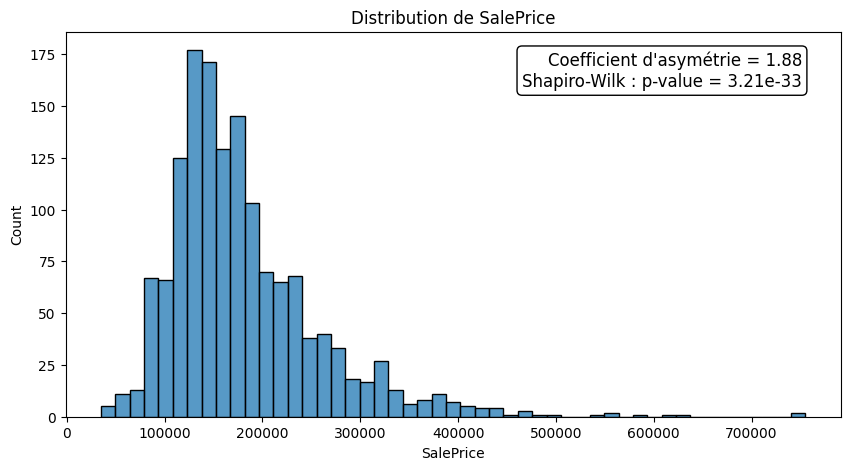

In [5]:
coeff_asymetrie = train['SalePrice'].skew()
test_shapiro = shapiro(train['SalePrice'])

plt.figure(figsize=(10, 5))
sns.histplot(train['SalePrice'], kde=False)
plt.title('Distribution de SalePrice')
annotations = f'Coefficient d\'asymétrie = {coeff_asymetrie:.2f}\nShapiro-Wilk : p-value = {test_shapiro[1]:.2e}'
plt.annotate(annotations, xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.show()

On remarque graphiquement que la distribution est étalée à droite, le coefficient d'asymétrie de 1.88 vient confirmer cette hypothèse. De plus, la p.value assosciée au test de shapiro étant inférieure à 0.05, on rejette l'hypothèse nulle de normalité. On peut donc conclure que la variable cible n'est pas normalement distribuée. Pour réduire cette étalement on va lui appliquer une transformation logarithmique.

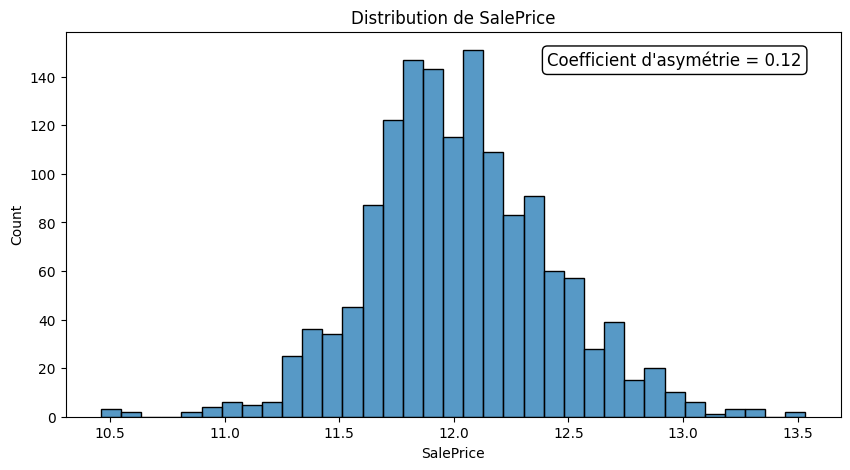

In [6]:
train['SalePrice'] = np.log1p(train['SalePrice'])
coeff_asymetrie = train['SalePrice'].skew()

plt.figure(figsize=(10, 5))
sns.histplot(train['SalePrice'], kde=False)
plt.title('Distribution de SalePrice')
# Annotating skewness value and Shapiro-Wilk test results
annotations = f'Coefficient d\'asymétrie = {coeff_asymetrie:.2f}'
plt.annotate(annotations, xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.show()

### 1.2.2. Variable importantes et corrélation

Pour extraire les variables les plus importantes de notre jeu de données, on va utiliser la méthode de corrélation. Les variables qui auront un coefficient de corrélation avec SalePrice inférieur à 0.3 en valeur absolue seront éliminées.

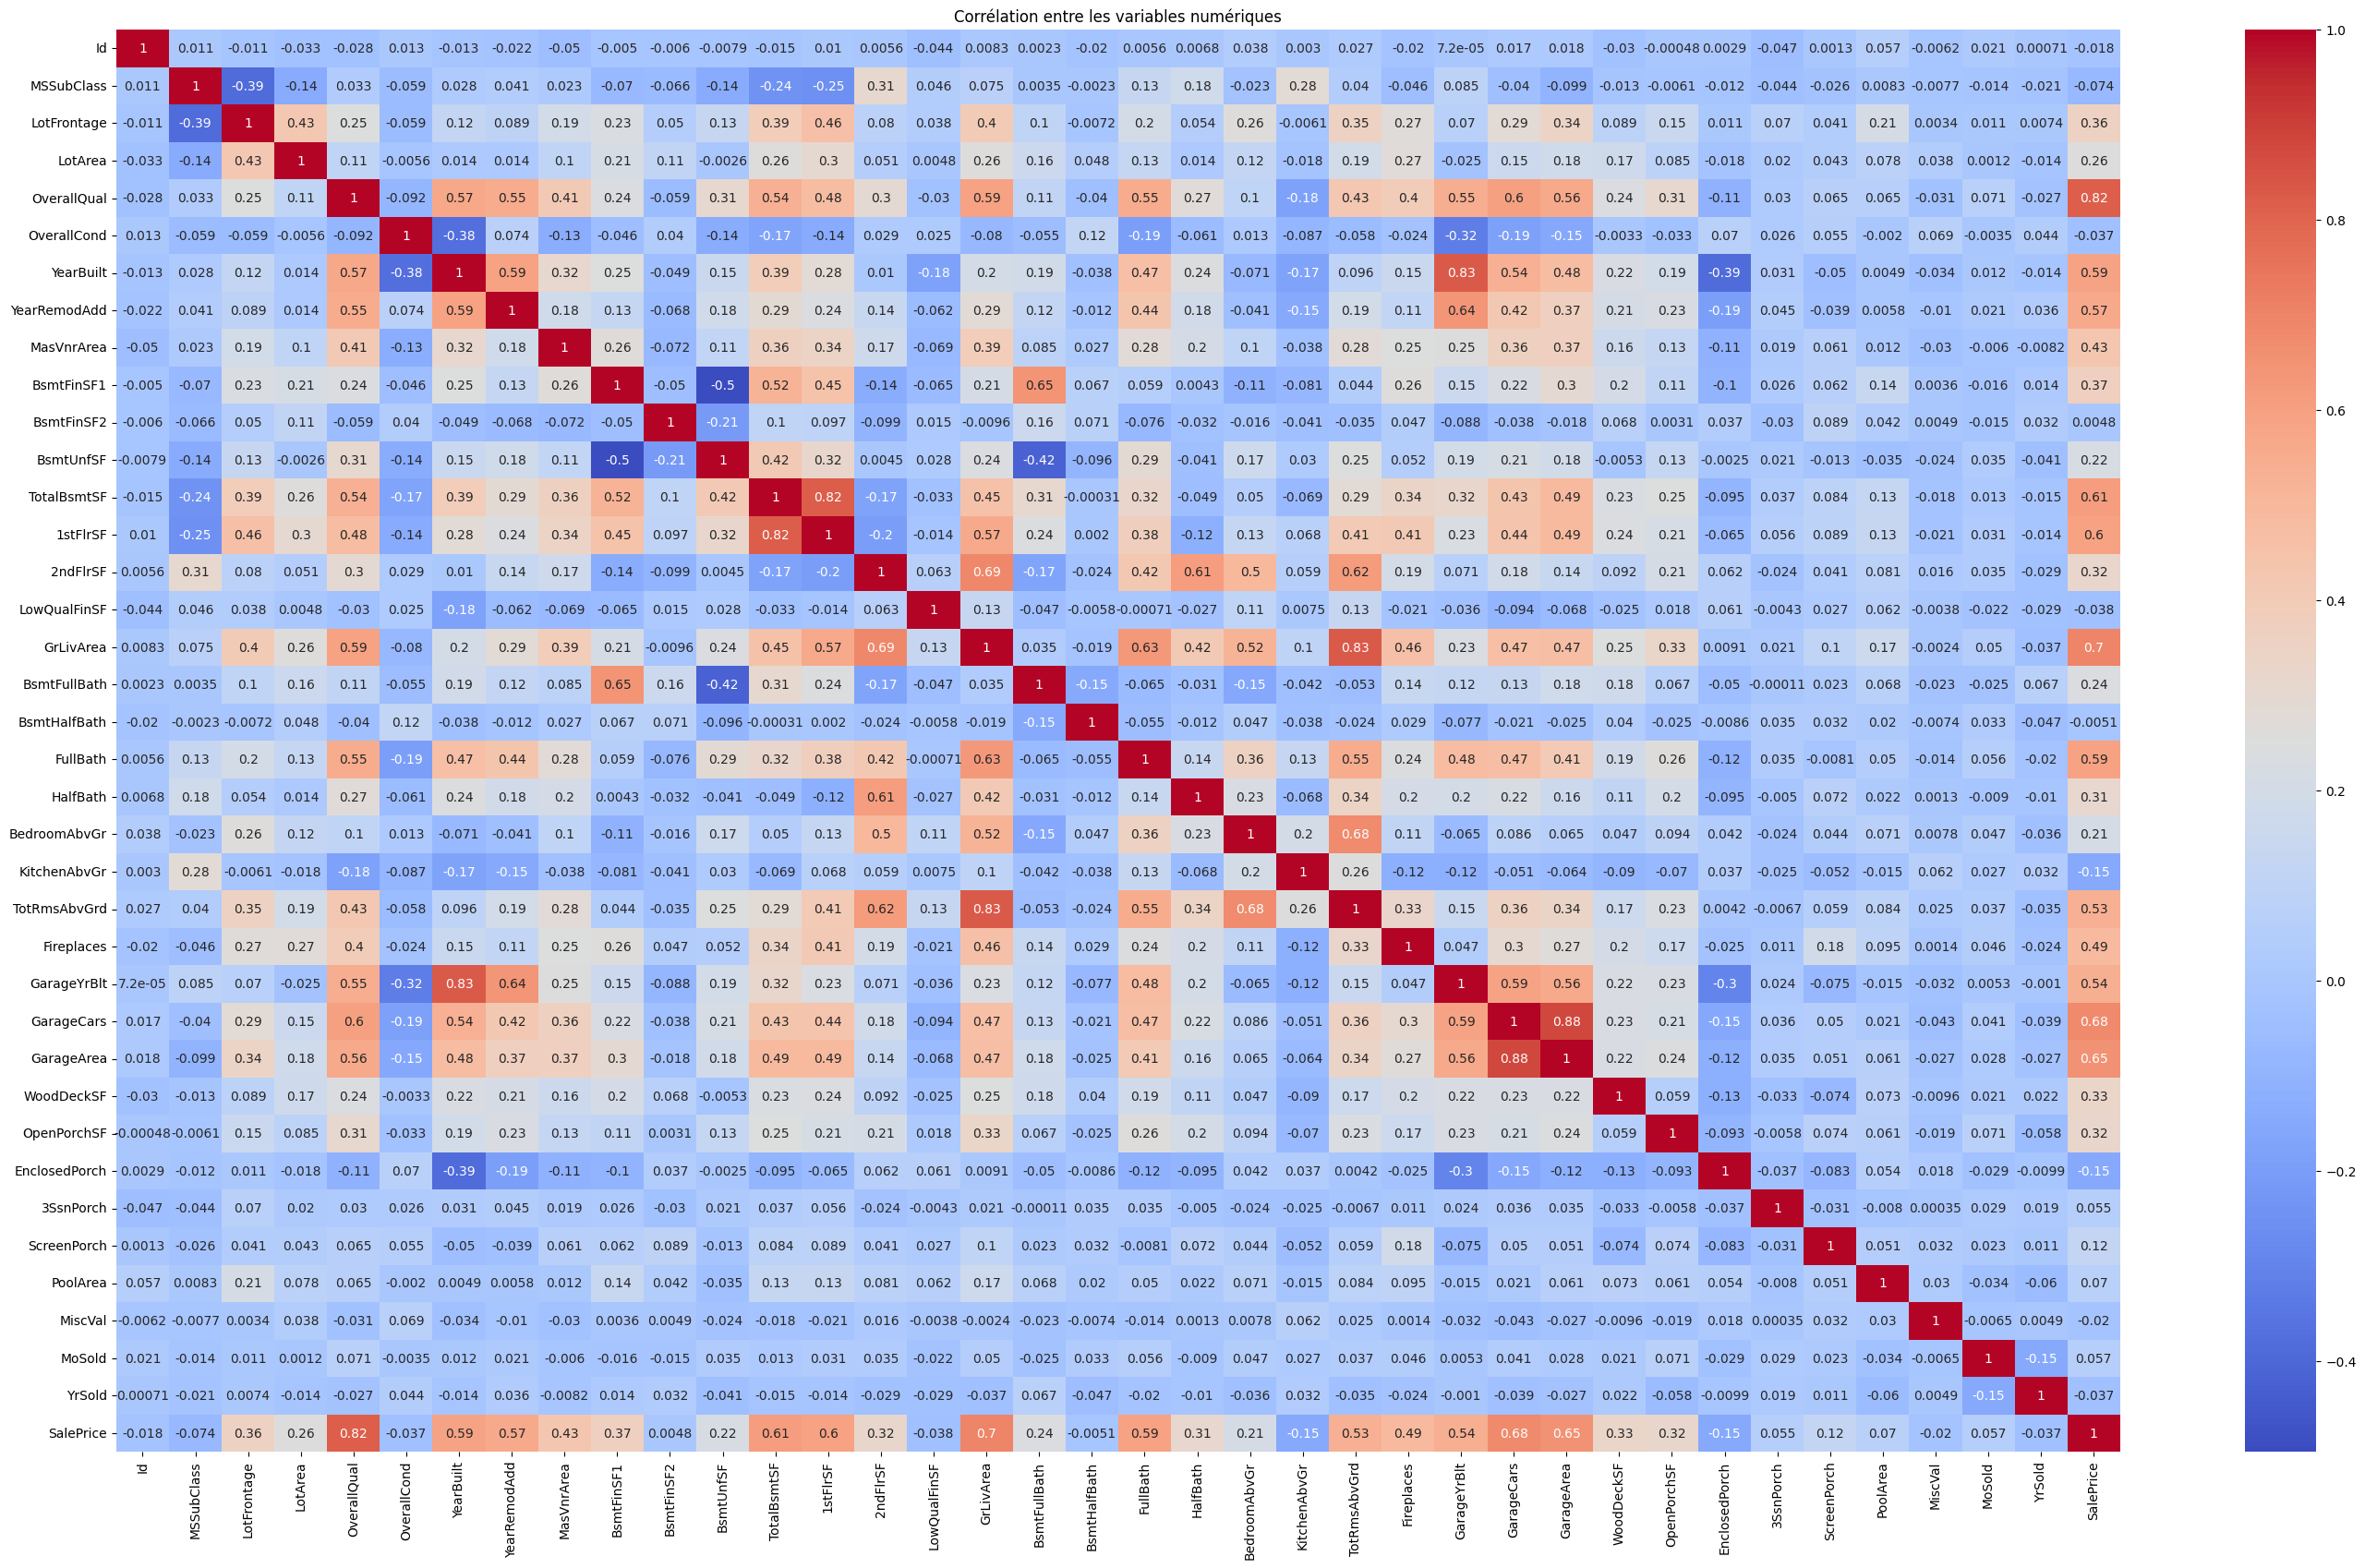

In [7]:
plt.figure(figsize=(35, 20))
sns.heatmap(train.select_dtypes(include=[np.number]).corr(), annot = True, cmap = 'coolwarm')
plt.title('Corrélation entre les variables numériques')
plt.show()

On remarque qu'il y a des variables explicatives qui sont fortement corrélées entre elles. On va donc les éliminer pour éviter le problème de multicolinéarité.

In [8]:
#On extrait la combinaison de variable explciative qui ont une corrélation supérieur à 0.8
correlation = train.select_dtypes(include=[np.number]).corr()
top_corr = correlation.where(np.triu(np.abs(correlation) > 0.8, k=1)).stack().reset_index()
top_corr.columns = ['Variable 1', 'Variable 2', 'Corrélation']
top_corr['Corrélation'] = top_corr['Corrélation'].abs()
top_corr = top_corr.sort_values(by='Corrélation', ascending=False)
top_corr

,Variable 1,Variable 2,Corrélation
4,GarageCars,GarageArea,0.882475
1,YearBuilt,GarageYrBlt,0.825667
3,GrLivArea,TotRmsAbvGrd,0.825489
2,TotalBsmtSF,1stFlrSF,0.819530
0,OverallQual,SalePrice,0.817185


### 1.2.3. Suppression des outliers

In [9]:
def outlier_detection_train(df, n, columns):
    rows = []
    will_drop_train = []
    for col in columns:
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_point = 1.5 * IQR
        rows.extend(df[(df[col] < Q1 - outlier_point)|(df[col] > Q3 + outlier_point)].index)
    for r, c in Counter(rows).items():
        if c >= n: will_drop_train.append(r)
    
    print(f"Number of rows to be dropped: {len(will_drop_train)}")
    
    return will_drop_train

will_drop_train = outlier_detection_train(train, 5, train.select_dtypes(["float", "int"]).columns)

train.drop(will_drop_train, inplace=True, axis=0)


Number of rows to be dropped: 33


### 1.2.4. Gestion des valeurs manquantes

              total number of missing data  total percent of missing data
PoolQC                                2880                      99.792100
MiscFeature                           2786                      96.534997
Alley                                 2690                      93.208593
Fence                                 2322                      80.457380
MasVnrType                            1750                      60.637561
FireplaceQu                           1415                      49.029799
LotFrontage                            476                      16.493416
GarageYrBlt                            155                       5.370755
GarageFinish                           155                       5.370755
GarageQual                             155                       5.370755
GarageCond                             155                       5.370755
GarageType                             153                       5.301455
BsmtExposure                          

<Axes: >

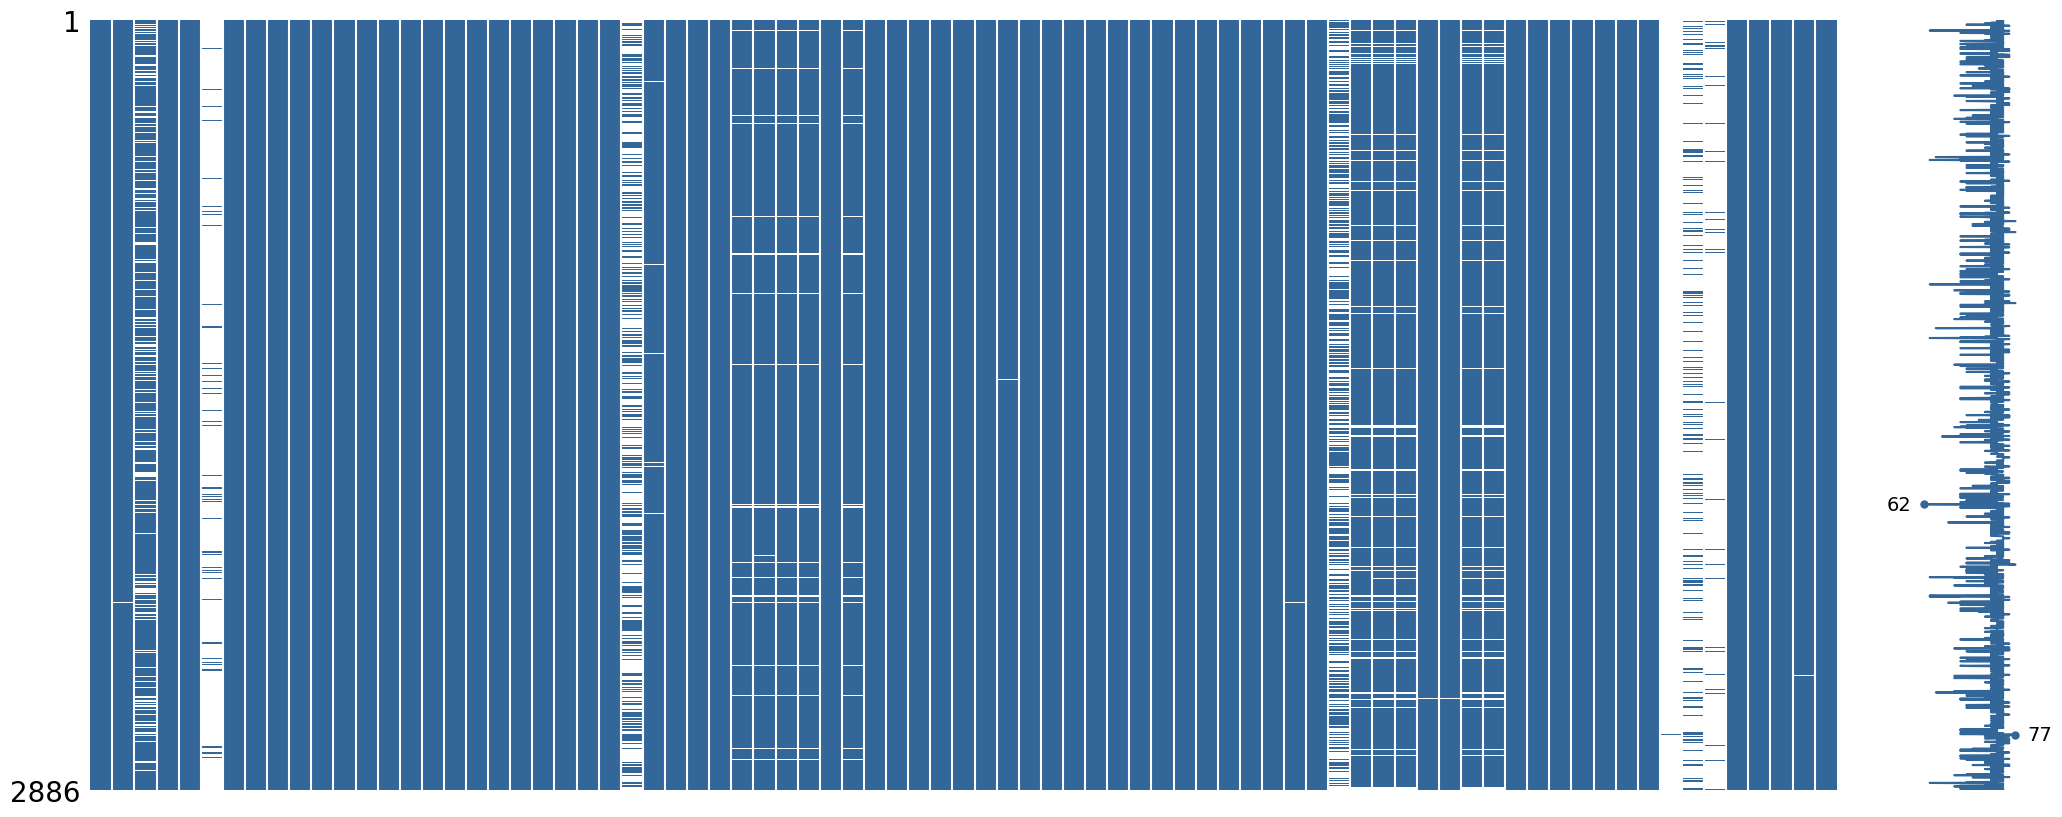

In [10]:
y_train = train['SalePrice']

train_and_test_df = pd.concat([train, test], axis = 0)
train_and_test_df = train_and_test_df.drop(["Id", "SalePrice"], axis = 1)

number_of_missing_df = train_and_test_df.isnull().sum().sort_values(ascending = False)
percent_of_missing_df = ((train_and_test_df.isnull().sum() / train_and_test_df.isnull().count())*100).sort_values(ascending = False)

missing_df = pd.concat([number_of_missing_df,
                        percent_of_missing_df],
                        keys = ["total number of missing data", 'total percent of missing data'],
                        axis = 1)


print(missing_df.head(20))

msno.matrix(train_and_test_df, color=(0.2, 0.4, 0.6))

### 1.2.5. Suppression des variables inutiles

In [11]:
train_and_test_df = train_and_test_df.drop((missing_df[missing_df["total number of missing data"] > 100]).index, axis = 1)
train_and_test_df.isnull().sum().sort_values(ascending = False)

BsmtCond         81
BsmtExposure     81
BsmtQual         80
BsmtFinType2     79
BsmtFinType1     78
                 ..
Foundation        0
Heating           0
HeatingQC         0
CentralAir        0
SaleCondition     0
Length: 67, dtype: int64

### 1.2.6. Remplissage des valeurs manquantes

In [12]:
numeric_data = [column for column in train_and_test_df.select_dtypes(["int", "float"])]
categoric_data = [column for column in train_and_test_df.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    train_and_test_df[col] = train_and_test_df[col].fillna(train_and_test_df[col].median())
        
for col in categoric_data:
    train_and_test_df[col] = train_and_test_df[col].fillna(train_and_test_df[col].value_counts().index[0])

train_and_test_df.isnull().sum().sum()

0

### 1.2.7. Autres distributions asymétriques

In [13]:
numeric_data = [column for column in train_and_test_df.select_dtypes(["int", "float"])]
vars_skewed = train_and_test_df[numeric_data].apply(lambda x: skew(x)).sort_values()

for var in vars_skewed.index:
    train_and_test_df[var] = np.log1p(train_and_test_df[var])

train_and_test_df = train_and_test_df.drop(["GarageArea", "1stFlrSF", "TotRmsAbvGrd"],
                                          axis = 1)

train_and_test_df = pd.get_dummies(train_and_test_df, drop_first = True)
train_and_test_df.head()

x_train = train_and_test_df[:len(train)]
x_test = train_and_test_df[len(train):]

# 2. Modélisation

Nous allons tester plusieurs modèles de régression pour prédire le prix de vente des maisons. La validation croisée sera utilisée pour évaluer les performances de chaque modèle.

## 2.1. Setup de la validation croisée

In [14]:
k_fold = KFold(n_splits = 20, shuffle = True, random_state = 42)

def cv_rmse(model, X = x_train):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring = "neg_mean_squared_error", cv = k_fold))
    return rmse

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred, squared = False))

## 2.2. Modèles de régression

In [18]:
xgb = make_pipeline(RobustScaler(),
                    XGBRegressor(colsample_bytree = 0.5, n_estimators = 6000,
                                 max_depth = 4, learning_rate = 0.01, gamma = 0.45,
                                 subsample = 0.5, random_state = 123, reg_alpha = 0.00006,
                                 reg_lambda = None, nthread = -1))

score = cv_rmse(xgb)
print("Xgboost model's cross validation score: ", score.mean())

Xgboost model's cross validation score:  0.12875117767397573


In [19]:
lgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective = 'regression', num_leaves = 5,
                                    learning_rate = 0.01, n_estimators = 6000,
                                    max_bin = 55, bagging_fraction = 0.8,
                                    bagging_freq = 5, feature_fraction = 0.2319,
                                    feature_fraction_seed = 9, bagging_seed = 9,
                                    min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11))

score = cv_rmse(lgbm)
print("LGBM model's cross validation score: ", score.mean())

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [32]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = np.arange(1, 25, 0.25), cv = k_fold))

score = cv_rmse(ridge)
print("Ridge model's cross validation score: ", score.mean())

Ridge model's cross validation score:  0.11056591838529797


In [34]:
lasso = make_pipeline(RobustScaler(), LassoCV(alphas = np.arange(0.0001, 0.02, 0.0001), cv = k_fold))

score = cv_rmse(lasso)
print("Lasso model's cross validation score: ", score.mean())

Lasso model's cross validation score:  0.11178845831409254


In [37]:
gbr = make_pipeline(RobustScaler(), GradientBoostingRegressor(n_estimators = 6000, learning_rate = 0.01,
                                                                max_depth = 4, max_features = 'sqrt',
                                                                min_samples_leaf = 15, min_samples_split = 10,
                                                                loss = 'huber', random_state = 123))

score = cv_rmse(gbr)
print("Gradient Boosting model's cross validation score: ", score.mean())

Gradient Boosting model's cross validation score:  0.1099189709876683


In [38]:
rf = make_pipeline(RobustScaler(),
                   RandomForestRegressor(n_estimators = 2500, max_depth = 15,
                                         min_samples_split = 6, min_samples_leaf = 6,
                                         random_state = 11))

score = cv_rmse(rf)
print("Random forest model's cross validation score: ", score.mean())

Random Forest model's cross validation score:  0.1940501565091156


In [39]:
svm = make_pipeline(RobustScaler(), SVR(C = 20, epsilon = 0.008, gamma = 0.0003))

score = cv_rmse(svm)
print("Support Vector Machine model's cross validation score: ", score.mean())

Support Vector Machine model's cross validation score:  0.10788656482956202


In [42]:
stack_gen = StackingCVRegressor(regressors = (xgb, lgbm, ridge, lasso, gbr, rf, svm),
                                meta_regressor = xgb,
                                use_features_in_secondary = True)

In [43]:
gbr_model = gbr.fit(x_train, y_train)
gbr_score = rmsle(y_train, gbr_model.predict(x_train))
print("RMSLE score of xgboost model on full data:", gbr_score)

lgbm_model = lgbm.fit(x_train, y_train)
lgbm_score = rmsle(y_train, lgbm_model.predict(x_train))
print("RMSLE score of lgbm model on full data:", lgbm_score)

ridge_model = ridge.fit(x_train, y_train)
ridge_score = rmsle(y_train, ridge_model.predict(x_train))
print("RMSLE score of ridge model on full data:", ridge_score)

lasso_model = lasso.fit(x_train, y_train)
lasso_score = rmsle(y_train, lasso_model.predict(x_train))
print("RMSLE score of lasso model on full data:", lasso_score)

xgb_model = xgb.fit(x_train, y_train)
xgb_score = rmsle(y_train, xgb_model.predict(x_train))
print("RMSLE score of xgb model on full data:", xgb_score)

rf_model = rf.fit(x_train, y_train)
rf_score = rmsle(y_train, rf_model.predict(x_train))
print("RMSLE score of rf model on full data:", rf_score)

svm_model = svm.fit(x_train, y_train)
svm_score = rmsle(y_train, svm_model.predict(x_train))
print("RMSLE score of svm model on full data:", svm_score)

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


RMSLE score of xgboost model on full data: 0.06813367075311952
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


RMSLE score of ridge model on full data: 0.08789070858329358


C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


RMSLE score of lasso model on full data: 0.08740880474986325


C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


RMSLE score of xgb model on full data: 0.09391759262986361


C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


RMSLE score of rf model on full data: 0.08627290706938003
RMSLE score of svm model on full data: 0.08861893511159823


C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


In [44]:
stacked_model = stack_gen.fit(np.array(x_train), np.array(y_train))
stacked_score = rmsle(y_train, stacked_model.predict(x_train))

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fi

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


In [45]:
y_pred = np.floor(np.expm1(stacked_model.predict(x_test)))
y_pred[0:5]

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fi

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


array([118791., 158121., 182897., 195375., 191104.], dtype=float32)

In [46]:
submission = pd.DataFrame()
submission["Id"] = test["Id"]
submission["SalePrice"] = y_pred
submission.to_csv("submission.csv", index = False)
submission.head(n = 10)

,Id,SalePrice
0,1461,118791.0
1,1462,158121.0
2,1463,182897.0
3,1464,195375.0
4,1465,191104.0
5,1466,169586.0
6,1467,169808.0
7,1468,161104.0
8,1469,192363.0
9,1470,121129.0
